In [1]:
using Plots, Flux, DiffEqFlux, StochasticDiffEq, Distances, StatsBase, Statistics, LinearAlgebra, Random, DiffEqSensitivity, Zygote, MultivariateStats, Optim

In [2]:
## create drift and diffusion function to generate trajectories from Ornstein-Uhlenbeck process
function ornstein_uhlenbeck!(dx, x, p, t)
    x1 = x[1]
    θ = p[1]
    dx[1] = dx1 = -θ*x1
end

function ornstein_uhlenbeck_noise!(dx, x, p, t)
    dx[1] = √(2)
end

ornstein_uhlenbeck_noise! (generic function with 1 method)

In [3]:
## set up initial condition, time grid, and true parameter for OU process
x0 = [1.0]
tspan = (0.0, 1.0)
n_steps = 20
tsteps = range(tspan[1],tspan[2],length=n_steps)
ou_p_true = [3.0]
prob_sde = SDEProblem(ornstein_uhlenbeck!,ornstein_uhlenbeck_noise!,x0,tspan)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: [1.0]

In [4]:
## create generator for OU process
function ou_generator(p,n_sim)
    # create an ensemble problem to solve the OU sde n_sim times
    ensembleprob = EnsembleProblem(prob_sde)

    # solve this ensemble problem n_sim times with parameter p
    sim = solve(ensembleprob,SOSRI(),p=p,sensealg=ForwardDiffSensitivity(),saveat=tsteps,trajectories=n_sim)

    # arrange the solutions into an array where each column is a single trajectory
    sim_mat = Array(sim)
    for i in 1:n_sim
        if i==1
            global sim_points = transpose(sim_mat[:,:,i])[:]
        else
            sim_points = hcat(sim_points,transpose(sim_mat[:,:,i])[:])
        end
    end

    # return this array of trajectories
    return sim_points
end

ou_generator (generic function with 1 method)

In [5]:
# Generate true data set
Random.seed!(12435)
N = 1000 # number of trajectories
true_data = ou_generator(ou_p_true,N);

# compute median heuristic
SqDistMat = pairwise(SqEuclidean(),true_data,dims=2);
σ₀ = 1/median(SqDistMat);

# set up Gaussian kernel for MMD
k(x) = exp(-σ₀*(x^2));

In [6]:
## set up neural sde where drift and diffusion function are simple 1 layer, 1 node "neural nets" (i.e. they are just linear functions a*x + b)
drift_dxdt = FastChain(FastDense(1,1));
diffusion_dxdt = FastChain(FastDense(1,1));

neuralsde = NeuralDSDE(drift_dxdt,diffusion_dxdt,tspan,SOSRI(),sensealg=ForwardDiffSensitivity(),saveat = tsteps);

# create generator function to solve the neural SDE once with parameters p and initial condtion x0 (given above for the OU SDE)
function generate_neuralsde(p)
    return Array(neuralsde(x0,p))
end

generate_neuralsde (generic function with 1 method)

In [7]:
## create function to compute unbiased estimator of MMD between two datasets p and q (whose columns contain the sampled paths)
function mmdU(p,q,k)
    # compute number of sampled paths for both distributions
    m = size(p)[2]
    n = size(q)[2]

    # compute the pairwise distance matrices between all possible pairs (pp,qq,pq)
    D_pp = pairwise(Euclidean(),p,dims=2)
    D_qq = pairwise(Euclidean(),q,dims=2)
    D_pq = pairwise(Euclidean(),p,q,dims=2)

    # evaluate the kernel function for all possible pairs (pp,qq,pq)
    K_pp = k.(D_pp)
    K_qq = k.(D_qq)
    K_pq = k.(D_pq)

    # compute estimate and return
    (1/(m*(m-1)))*(sum(K_pp) - tr(K_pp)) + (1/(n*(n-1)))*(sum(K_qq)-tr(K_qq)) - (2/(m*n))*sum(K_pq)
end

mmdU (generic function with 1 method)

In [8]:
## set up loss function (MMD) for neural_sde problem
## n is the number of simulated trajectories to compute for current parameter vector
function loss_neuralsde(p; n = 100)
    # use generate_neuralsde to solve the neural sde n times with the parameter vector p
    samples = [generate_neuralsde(p) for i in 1:n]

    # arrange the sampled trajectories into columns in an array sim_data
    for i in 1:n
        if i == 1
            global sim_data = transpose(samples[i])[:]
        else
            sim_data = hcat(sim_data,transpose(samples[i])[:])
        end
    end

    # compute the MMD between the simulated and true data using the kernel function k
    loss = mmdU(true_data,sim_data,k)

    # return the loss and the simulated data for further analysis
    return loss, sim_data
end

loss_neuralsde (generic function with 1 method)

In [11]:
## initial parameter vector for gradient descent (all parameters set to 1)
## note that when p=[-3,0,0,√2] we get the same system as OU sde
ps = ones(length(neuralsde.p))

## use ADAM optimiser
opt = ADAM(0.25)

## First round of training with n_sim = 10
n_sim = 10

## initialise arrays to hold losses and parameter vectors during training
my_losses = []
my_params = []

## set up callback store losses and parameters
callback = function(p, loss, sim_data)
    global my_losses, my_params
    
    push!(my_losses,copy(loss));
    push!(my_params,copy(p));

    return false
end

#8 (generic function with 1 method)

In [12]:
## first round of training with only 10 simulated trajectories at each training step
Random.seed!(65474)
result1 = DiffEqFlux.sciml_train((p) -> loss_neuralsde(p, n = n_sim),  
                                 ps, opt,
                                 cb = callback, maxiters = 100)

loss: 0.0739: 100%|█████████████████████████████████████| Time: 0:04:55


 * Status: success

 * Candidate solution
    Final objective value:     7.392812e-02

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   299  (vs limit Inf)
    Iterations:    100
    f(x) calls:    100
    ∇f(x) calls:   100


In [13]:
## restructure parameter vecotrs into an array where each row is the parameter vector at one of the training iterations
my_params = [x[j] for x in my_params, j=1:4]

## get last parameter vector from result1
p_optim_1 = result1.minimizer

4-element Array{Float64,1}:
 -2.443467211759813
  0.279979303918582
  1.2746106309045815
  0.6517478857465008

In [14]:
## restart ADAM training with last parameter vector and use 100 simulated trajectories now 
n_sim = 100
my_losses_2 = []
my_params_2 = []
callback = function(p, loss, sim_data)
    global my_losses_2, my_params_2

    push!(my_losses_2,copy(loss));
    push!(my_params_2,copy(p));

    return false
end

#14 (generic function with 1 method)

In [15]:
result2 = DiffEqFlux.sciml_train((p) -> loss_neuralsde(p, n = n_sim),  
                                 p_optim_1, opt,
                                 cb = callback, maxiters = 100)

loss: 0.00491: 100%|████████████████████████████████████| Time: 0:06:02


 * Status: success

 * Candidate solution
    Final objective value:     4.906524e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   367  (vs limit Inf)
    Iterations:    100
    f(x) calls:    100
    ∇f(x) calls:   100


In [16]:
my_params_2 = [x[j] for x in my_params_2, j=1:4]

p_optim_2 = result2.minimizer

4-element Array{Float64,1}:
 -3.3280972141506195
 -0.04796376259162635
  0.07515280676689212
  1.3271826863077405

In [17]:
## we now use the last vectors from each run to simulate N=1000 trajectories from neural sde model as well as the one which achieved the smallest absolute loss in both runs

# print minimum absolute loss for both runs
println(minimum(abs.(my_losses)))
println(minimum(abs.(my_losses_2))) # this is smaller so use best vector from second run

0.0004193391343099151
1.0689434115640495e-7


In [18]:
# sampled paths from last param vector in first run
samples_1 = [generate_neuralsde(p_optim_1) for i in 1:N]
mat_1 = Array(samples_1)
for i in 1:N
    if i == 1
        global sampled_data_1 = transpose(mat_1[i])[:]
    else
        sampled_data_1 = hcat(sampled_data_1,transpose(mat_1[i])[:])
    end
end

# sampled paths from last param vector in second run
samples_2 = [generate_neuralsde(p_optim_2) for i in 1:N]
mat_2 = Array(samples_2)
for i in 1:N
    if i == 1
        global sampled_data_2 = transpose(mat_2[i])[:]
    else
        sampled_data_2 = hcat(sampled_data_2,transpose(mat_2[i])[:])
    end
end

# sampled paths from best parameter vector
samples_best = [generate_neuralsde(my_params_2[argmin(abs.(my_losses)),:]) for i in 1:N]
mat_best = Array(samples_best)
for i in 1:N
    if i == 1
        global sampled_data_best = transpose(mat_best[i])[:]
    else
        sampled_data_best = hcat(sampled_data_best,transpose(mat_best[i])[:])
    end
end

In [19]:
# Analyse true data set and sampled ones using PCA
M_true = fit(PCA,true_data,maxoutdim=9,pratio=0.999)
P_true = projection(M_true)
μ_true = mean(M_true)
vars_true = principalvars(M_true)

M_1 = fit(PCA,sampled_data_1,maxoutdim=9,pratio=0.999)
P_1 = projection(M_1)
μ_1 = mean(M_1)
vars_1 = principalvars(M_1)

M_2 = fit(PCA,sampled_data_2,maxoutdim=9,pratio=0.999)
P_2 = projection(M_2)
μ_2 = mean(M_2)
vars_2 = principalvars(M_2)

M_best = fit(PCA,sampled_data_best,maxoutdim=9,pratio=0.999)
P_best = projection(M_best)
μ_best = mean(M_best)
vars_best = principalvars(M_best)

9-element Array{Float64,1}:
 2.353292498396049
 1.0685504100356527
 0.5183460263652225
 0.3024134142960406
 0.20134705666397254
 0.13979586719959364
 0.10653091823115377
 0.08480277001663347
 0.06710228434840206

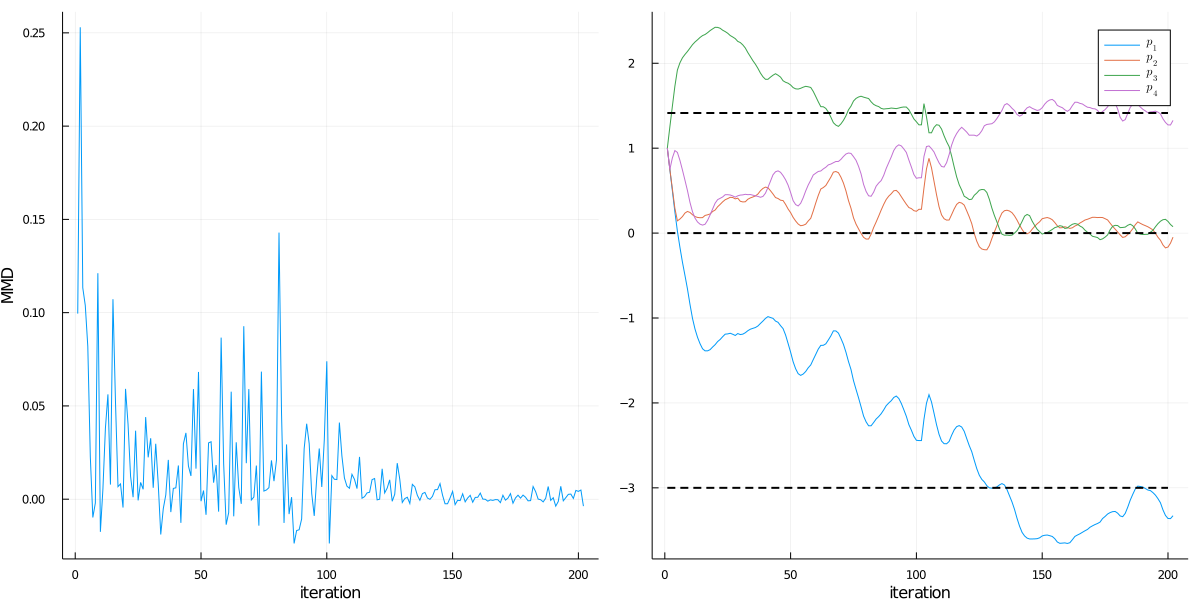

In [20]:
using LaTeXStrings
# plot losses from both runs as well as parameters
p1 = plot(vcat(my_losses,my_losses_2),legend=false,xlab="iteration",ylab="MMD")
p2 = plot(vcat(my_params[:,1],my_params_2[:,1]),xlab="iteration",label=L"p_1")
plot!(p2,vcat(my_params[:,2],my_params_2[:,2]),label=L"p_2")
plot!(p2,vcat(my_params[:,3],my_params_2[:,3]),label=L"p_3")
plot!(p2,vcat(my_params[:,4],my_params_2[:,4]),label=L"p_4")
plot!(p2,-3*ones(200),c=:black,lw=2,linestyle=:dash,label=false)
plot!(p2,zeros(200),c=:black,lw=2,linestyle=:dash,label=false)
plot!(p2,sqrt(2)*ones(200),c=:black,lw=2,linestyle=:dash,label=false)
plot(p1,p2,size=(1200,600),layout=grid(1,2))

In [21]:
## plot trajectories, mean trajectories and principal variances
p1 = plot(tsteps,true_data[:,1],c=:blue,label="true data",title="Final result from run 1",xlab=L"t")
plot!(p1,tsteps,sampled_data_1[:,1],c=:red,label="simulated data")
for i in 2:N # use N here if want all true data samples
    plot!(p1,tsteps,true_data[:,i],c=:blue,label=false)
    plot!(p1,tsteps,sampled_data_1[:,i],c=:red,label=false)
end
plot(p1)

p2 = plot(tsteps,true_data[:,1],c=:blue,label="true data",title="Final result from run 2",xlab=L"t")
plot!(p2,tsteps,sampled_data_2[:,1],c=:red,label="simulated data")
for i in 2:N # use N here if want all true data samples
    plot!(p2,tsteps,true_data[:,i],c=:blue,label=false)
    plot!(p2,tsteps,sampled_data_2[:,i],c=:red,label=false)
end
plot(p2)

p3 = plot(tsteps,true_data[:,1],c=:blue,label="true data",title="Best result from both runs",xlab=L"t")
plot!(p3,tsteps,sampled_data_best[:,1],c=:red,label="simulated data")
for i in 2:N # use N here if want all true data samples
    plot!(p3,tsteps,true_data[:,i],c=:blue,label=false)
    plot!(p3,tsteps,sampled_data_best[:,i],c=:red,label=false)
end
plot(p3)

p4 = plot(tsteps,μ_true,label="true mean",xlab=L"t",title="Mean trajectories using run 1")
plot!(p4,tsteps,μ_1,label="simulated mean")

p5 = plot(tsteps,μ_true,label="true mean",xlab=L"t",title="Mean trajectories using run 2")
plot!(p5,tsteps,μ_2,label="simulated mean")

p6 = plot(tsteps,μ_true,label="true mean",xlab=L"t",title="Mean trajectories using best result")
plot!(p6,tsteps,μ_best,label="simulated mean")

p7 = plot(vars_true,label="true",title="Principal Variances using run 1")
plot!(p7,vars_1,label="simulated")

p8 = plot(vars_true,label="true",title="Principal Variances using run 2")
plot!(p8,vars_2,label="simulated")

p9 = plot(vars_true,label="true",title="Principal Variances using best result")
plot!(vars_best,label="simulated")

plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,size=(1200,850),layout=grid(3,3))

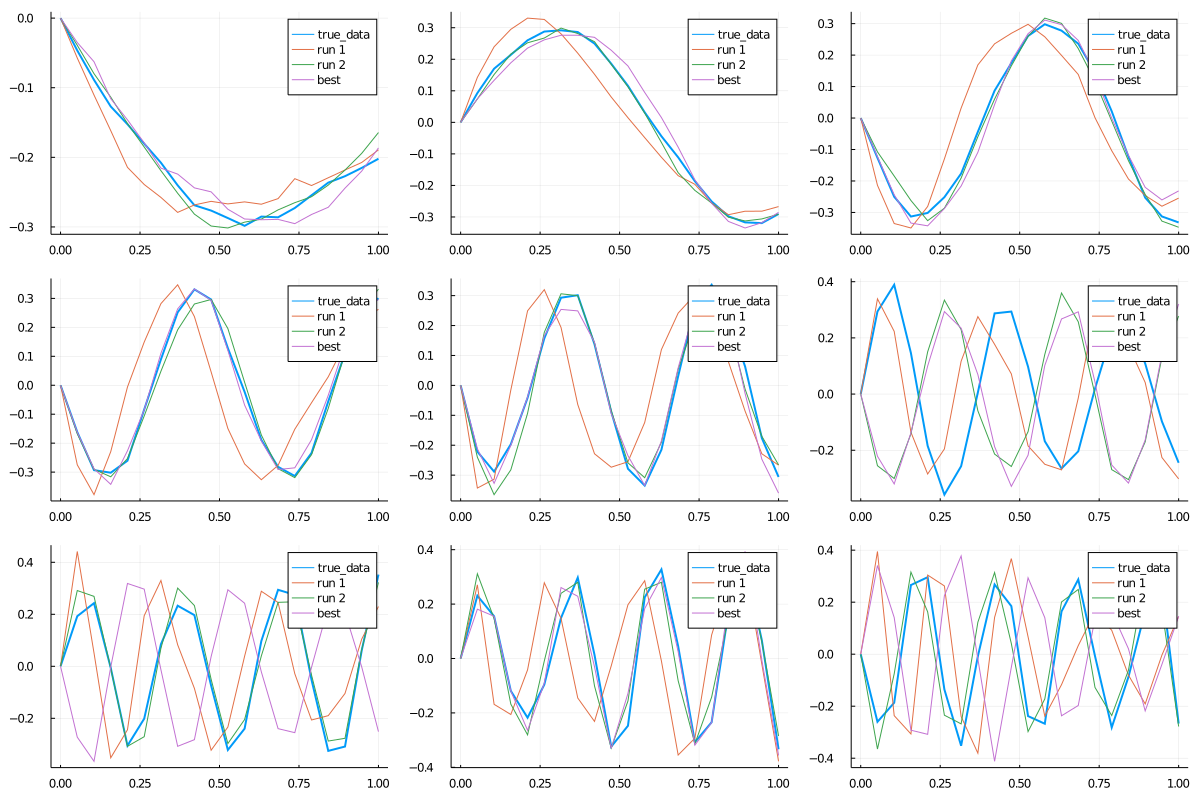

In [22]:
## plots of principal components
p1 = plot(tsteps,P_true[:,1],label="true_data",lw=2)
p2 = plot(tsteps,P_true[:,2],label="true_data",lw=2)
p3 = plot(tsteps,P_true[:,3],label="true_data",lw=2)
p4 = plot(tsteps,P_true[:,4],label="true_data",lw=2)
p5 = plot(tsteps,P_true[:,5],label="true_data",lw=2)
p6 = plot(tsteps,P_true[:,6],label="true_data",lw=2)
p7 = plot(tsteps,P_true[:,7],label="true_data",lw=2)
p8 = plot(tsteps,P_true[:,8],label="true_data",lw=2)
p9 = plot(tsteps,P_true[:,9],label="true_data",lw=2)

plot!(p1,tsteps,P_1[:,1],label="run 1")
plot!(p2,tsteps,P_1[:,2],label="run 1")
plot!(p3,tsteps,P_1[:,3],label="run 1")
plot!(p4,tsteps,P_1[:,4],label="run 1")
plot!(p5,tsteps,P_1[:,5],label="run 1")
plot!(p6,tsteps,P_1[:,6],label="run 1")
plot!(p7,tsteps,P_1[:,7],label="run 1")
plot!(p8,tsteps,P_1[:,8],label="run 1")
plot!(p9,tsteps,P_1[:,9],label="run 1")

plot!(p1,tsteps,P_2[:,1],label="run 2")
plot!(p2,tsteps,P_2[:,2],label="run 2")
plot!(p3,tsteps,P_2[:,3],label="run 2")
plot!(p4,tsteps,P_2[:,4],label="run 2")
plot!(p5,tsteps,P_2[:,5],label="run 2")
plot!(p6,tsteps,P_2[:,6],label="run 2")
plot!(p7,tsteps,P_2[:,7],label="run 2")
plot!(p8,tsteps,P_2[:,8],label="run 2")
plot!(p9,tsteps,P_2[:,9],label="run 2")

plot!(p1,tsteps,P_best[:,1],label="best")
plot!(p2,tsteps,P_best[:,2],label="best")
plot!(p3,tsteps,P_best[:,3],label="best")
plot!(p4,tsteps,P_best[:,4],label="best")
plot!(p5,tsteps,P_best[:,5],label="best")
plot!(p6,tsteps,P_best[:,6],label="best")
plot!(p7,tsteps,P_best[:,7],label="best")
plot!(p8,tsteps,P_best[:,8],label="best")
plot!(p9,tsteps,P_best[:,9],label="best")

plt_1 = plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,size=(1200,800),layout =grid(3,3))